# IEEE-CIS Fraud Detection

**Author**: Delfi Kusuma Wardhani

## Introduction

### Dataset Description
Dataset can be downloaded from this link : https://www.kaggle.com/c/ieee-fraud-detection/data

The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features.

**Transaction Table**

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Identity Table**

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id_12 - id_38

## Objective
Create machine learning model to detect the fraud (anomaly) in dataset.

## Import Library

In [1]:
# Common import
import pandas as pd 
import numpy as np 

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns 

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Machine Learning Model
from sklearn.mixture import GaussianMixture

# Evaluation
from sklearn.metrics import classification_report, average_precision_score


## Data Loading

In [2]:
# Use this code if you use google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the train_transaction file
data1 = pd.read_csv('/content/drive/MyDrive/Job Interview Technical Test/Fraud Detection Test/train_transaction.csv')
data1.set_index('TransactionID', inplace=True)
data1.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Load the train_identity file
data2 = pd.read_csv('/content/drive/MyDrive/Job Interview Technical Test/Fraud Detection Test/train_identity.csv')
data2.set_index('TransactionID', inplace=True)
data2.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
# Show info on first file
print('Train Transaction Table')
print(data1.info())
print(data1.shape)

Train Transaction Table
<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 393 entries, isFraud to V339
dtypes: float64(376), int64(3), object(14)
memory usage: 1.7+ GB
None
(590540, 393)


The dataset contains 590540 rows of datas, and 393 columns

In [6]:
# Show info on second file
print('Train Identity Table')
print(data2.info())
print(data2.shape)

Train Identity Table
<class 'pandas.core.frame.DataFrame'>
Int64Index: 144233 entries, 2987004 to 3577534
Data columns (total 40 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_01       144233 non-null  float64
 1   id_02       140872 non-null  float64
 2   id_03       66324 non-null   float64
 3   id_04       66324 non-null   float64
 4   id_05       136865 non-null  float64
 5   id_06       136865 non-null  float64
 6   id_07       5155 non-null    float64
 7   id_08       5155 non-null    float64
 8   id_09       74926 non-null   float64
 9   id_10       74926 non-null   float64
 10  id_11       140978 non-null  float64
 11  id_12       144233 non-null  object 
 12  id_13       127320 non-null  float64
 13  id_14       80044 non-null   float64
 14  id_15       140985 non-null  object 
 15  id_16       129340 non-null  object 
 16  id_17       139369 non-null  float64
 17  id_18       45113 non-null   float64
 18  id_19       1393

In [7]:
# Merging the two dataframes with TransactionID as index
df = pd.concat([data1, data2], axis=1)
df.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [8]:
# Show the info of the merged dataframe
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.9+ GB
None
(590540, 433)


Now the dataframe contains 433 columns of data

## Data Cleaning

In [8]:
# Show the sum of missing value and duplicated data
print('Missing value :','\n', df.isnull().sum())
print('Duplicated data : ', df.duplicated().sum())

Missing value : 
 isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 433, dtype: int64
Duplicated data :  3


There are a lot of missing values in the dataset. First, let's handle this 3 duplicated datas by just removing them.

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
# Show columns that have missing values more than 75%
df.columns[df.isnull().mean() > 0.75]

Index(['dist2', 'R_emaildomain', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14',
       'V138',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=208)

These columns have missing values ratio above 75%

In [11]:
perc = 75.0
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
df_mod = df.dropna(axis=1, 
                thresh=min_count)
df_mod.shape

(590537, 225)

In [12]:
df_mod[df_mod.isnull().any(axis=1)]

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,T,T,T,M2,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000
2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,M0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,T,T,T,M0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,NaN,111.0,NaN,NaN,NaN,M0,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.000000,1758.000000,925.000000,0.0,354.000000,0.0,135.0,0.000000,0.000000,0.000000,50.0,1404.0,790.0,0.000000,0.000000,0.000000
2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,56.0,56.0,56.0,T,T,T,M0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.0,47.950001,0.0,0.0,47.950001,47.950001,47.950001,0.0,0.0,0.0,0.000000,0.000000,0.000000
3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,T,F,F,M0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,gmail.com,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,T,F,F,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.00

In [13]:
# Show the unique values from each columns
for col in df_mod.columns:
  print(col,"==>",df_mod[col].unique())

isFraud ==> [0 1]
TransactionDT ==> [   86400    86401    86469 ... 15811079 15811088 15811131]
TransactionAmt ==> [  68.5    29.     59.   ...  557.54 1659.95  400.78]
ProductCD ==> ['W' 'H' 'C' 'S' 'R']
card1 ==> [13926  2755  4663 ... 13166  8767 18038]
card2 ==> [ nan 404. 490. 567. 514. 555. 360. 100. 111. 352. 375. 418. 303. 314.
 543. 583. 148. 321. 269. 361. 272. 399. 569. 453. 417. 512. 545. 266.
 114. 481. 452. 547. 383. 170. 343. 556. 285. 562. 302. 264. 558. 500.
 396. 103. 206. 143. 243. 476. 199. 174. 423. 446. 492. 523. 440. 528.
 161. 535. 354. 117. 455. 325. 158. 268. 122. 479. 147. 215. 480. 265.
 388. 408. 309. 415. 414. 437. 104. 225. 101. 134. 586. 191. 491. 369.
 322. 494. 532. 313. 474. 324. 475. 298. 429. 432. 553. 566. 599. 296.
 251. 310. 242. 204. 250. 270. 346. 316. 194. 587. 390. 135. 536. 254.
 226. 327. 420. 260. 413. 428. 561. 387. 411. 392. 203. 297. 136. 276.
 142. 527. 210. 184. 459. 118. 585. 106. 588. 449. 176. 177. 246. 439.
 503. 445. 172. 468. 23

There are still a lot of missing values

In [14]:
df.dropna(axis='columns')

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
TransactionID,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.50,W,13926,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
2987001,0,86401,29.00,W,2755,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2987002,0,86469,59.00,W,4663,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
2987003,0,86499,50.00,W,18132,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
2987004,0,86506,50.00,H,4497,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535,0,15811047,49.00,W,6550,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0
3577536,0,15811049,39.50,W,10444,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3577537,0,15811079,30.95,W,12037,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0


There are only 19 columns that has no missing values

In [15]:
# Impute the remain missing values with the mode
for column in df_mod.columns:
    df_mod[column].fillna(df_mod[column].mode()[0], inplace=True)

df_mod.isnull().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


isFraud           0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
                 ..
V317              0
V318              0
V319              0
V320              0
V321              0
Length: 225, dtype: int64

In [16]:
df_mod.shape

(590537, 225)

Now the remain columns in the dataset are 225

## Exploratory Data Analysis (EDA)

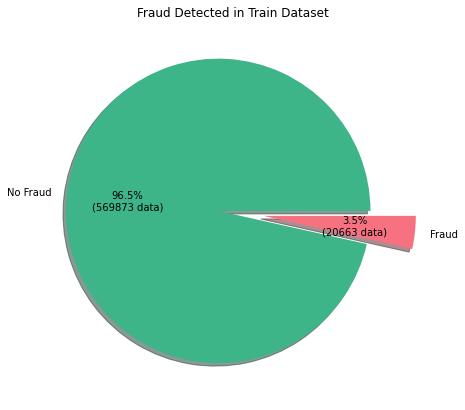

In [17]:
# A function to show the numbers of datas
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} data)".format(pct, absolute)

colors =["#3EB489", "#F67280"]
labels = ['No Fraud', 'Fraud']
explode=[0.1,0.2]

# Shows pie chart
plt.figure(figsize=(20,7))
plt.title('Fraud Detected in Train Dataset')
plt.pie(df_mod['isFraud'].value_counts(), autopct=lambda pct: func(pct, df_mod['isFraud'].value_counts()), 
        colors=colors, explode=explode, shadow=True, labels=labels)
plt.show()

From total of 590537 rows of data transaction, 20663 of them are detected as fraud.

In [18]:
df_mod.describe()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,590537.000000,5.905370e+05,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,...,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.00000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000,590537.000000
mean,0.034990,7.372291e+06,135.026838,9898.764587,361.927034,153.186474,199.471633,291.653832,86.822812,47.811727,14.092285,15.269597,0.005644,4.092206,5.571348,9.070988,2.848492,5.144601,4.480107,5.240369,10.241402,4.076246,32.539270,8.295060,94.144795,88.937227,15.726302,99.955529,20.123394,108.021355,77.278965,139.035132,0.999971,1.023826,1.041151,0.919074,0.935167,1.024080,1.038407,1.014602,...,0.817568,0.991139,0.088541,1.167617,0.031492,0.358570,0.183955,0.235469,1.103010,1.659799,1.239912,0.942579,2.313816,1.433392,0.328201,0.089033,0.298814,0.171652,0.04541,0.051890,0.251757,0.283136,0.264204,1.000007,139.746304,408.672451,230.408957,10.995819,118.192360,4.202111,39.173139,21.305700,43.226306,26.749508,109.816591,247.602074,162.150390,18.372196,42.071188,28.326153
std,0.183755,4.617221e+06,239.162568,4901.160484,156.677508,11.322630,41.157678,95.949432,2.537306,243.259862,133.569260,154.669231,0.150536,68.848633,25.786625,71.508586,61.727460,95.378815,16.674610,95.581685,94.336464,86.666437,129.364034,49.544207,157.551881,153.823836,48.557455,173.421938,64.900488,175.440678,153.627766,195.785419,0.005365,0.175790,0.236203,0.328542,0.350916,0.175282,0.224239,0.135791,...,0.920928,1.557058,0.338421,3.282390,0.190938,1.078986,0.430611,0.598688,0.768891,16.252414,3.775021,20.588660,39.526168,25.962750,3.261270,0.628348,3.175029,1.724205,0.28927,0.317978,0.481886,0.623605,0.528235,0.002603,2348.831806,4391.959312,3021.901358,116.253399,352.979737,102.374160,172.127083,95.805206,173.444397,116.734483,2270.015947,3980.012613,2793.322422,332.302323,473.494783,382.050276
min,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.027036e+06,43.321000,6019.000000,215.000000,150.000000,166.000000,205.000000,87.000000,0.000000,1.000000,1.000000,0.000000,0.000

If we take a look at the TransactionAmt (transaction amount) there are pretty high values of outlier datas as the max number is very far from the mean

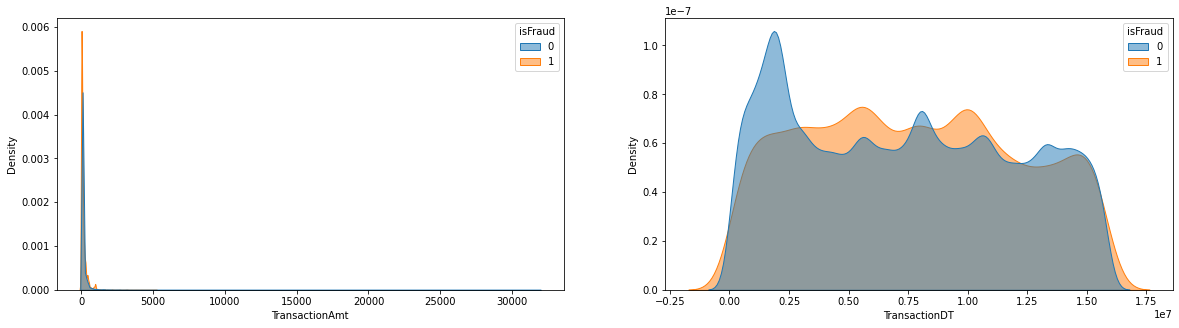

In [22]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.kdeplot(data=df_mod, x='TransactionAmt', hue='isFraud', fill=True, common_norm=False, alpha=.5)

plt.subplot(1,2,2)
sns.kdeplot(data=df_mod, x='TransactionDT', hue='isFraud', fill=True, common_norm=False, alpha=.5)
plt.show()

Now let's take a look closer for the fraud data and no fraud data

In [23]:
df_normal = df_mod[df_mod['isFraud']==0]
df_fraud = df_mod[df_mod['isFraud']==1]

In [24]:
df_normal.describe()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,569874.0,5.698740e+05,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.00000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,...,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000,569874.000000
mean,0.0,7.360770e+06,134.511311,9911.495462,361.835100,152.854385,199.730221,291.493653,86.832577,48.088567,13.314770,14.173135,0.005840,3.693897,5.722353,8.786277,2.517497,4.560905,4.580767,4.723551,9.747699,3.549720,32.813804,8.220331,96.157877,91.087925,16.098276,101.736726,20.59172,110.396512,79.145471,141.826397,0.999970,1.023844,1.040609,0.917364,0.932804,1.024272,1.038477,1.014608,...,0.799329,0.957752,0.086266,1.173324,0.031331,0.354377,0.181063,0.230616,1.097132,1.596546,1.220665,0.960226,2.281908,1.441708,0.325621,0.088730,0.298033,0.171754,0.044017,0.049950,0.239563,0.268379,0.250978,1.000007,140.579978,403.699315,228.537689,10.547476,117.448565,4.176779,37.941645,20.549666,41.955235,25.677259,111.096429,243.806234,161.620501,18.368405,41.624004,28.204234
std,0.0,4.623927e+06,239.395126,4905.662302,156.624835,10.890853,40.961289,96.415257,2.472211,244.175403,127.788199,147.486245,0.153209,65.839428,26.121485,68.689288,58.860927,91.023255,16.889159,91.239338,90.306733,82.601386,127.831309,47.898656,158.865596,155.264616,49.074844,174.728646,65.61579,176.759337,155.145179,196.974001,0.005462,0.175078,0.233212,0.330062,0.350292,0.175420,0.223966,0.135282,...,0.897430,1.472824,0.334145,3.314778,0.190494,1.081539,0.426478,0.589320,0.732911,14.822230,3.512093,20.955846,39.557077,26.379321,3.286122,0.632396,3.212855,1.747142,0.283283,0.309565,0.472351,0.608917,0.516764,0.002649,2389.800802,4431.714567,3069.892385,116.619576,351.039542,103.901247,169.941484,93.756972,169.442265,113.231291,2309.907375,4013.339967,2838.410481,337.452812,478.430819,387.437664
min,0.0,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.000000,0.00000,0.000000,-53.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,3.010638e+06,43.970000,6019.000000,215.000000,150.000000,166.000000,204.000000,87.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0

In [25]:
df_fraud.describe()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,20663.0,2.066300e+04,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.00000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.0,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,...,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.0,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000
mean,1.0,7.690033e+06,149.244779,9547.654164,364.462518,162.345303,192.339931,296.071480,86.553501,40.176644,35.53574,45.509413,0.000242,15.077336,1.406717,16.923148,11.977157,21.242608,1.703964,19.493926,23.857475,18.597541,24.967768,10.356047,38.625127,29.622175,5.467454,50.831099,7.207230,42.515850,25.801771,62.053622,1.0,1.023327,1.056091,0.966220,1.000339,1.018778,1.036490,1.014422,...,1.320573,1.911920,0.151285,1.010211,0.035910,0.474229,0.263708,0.369307,1.265112,3.404298,1.770750,0.455887,3.193825,1.204036,0.399361,0.097372,0.320379,0.168853,0.083821,0.105406,0.588056,0.690122,0.628950,1.0,116.754047,545.828757,282.017488,23.360863,138.705799,4.900737,73.137039,42.156677,78.281729,56.321550,74.519367,352.289202,176.764416,18.476726,54.404279,31.688605
std,0.0,4.416551e+06,232.212163,4762.051380,158.106030,17.487497,45.674180,81.945437,3.918803,216.354920,242.97626,287.813648,0.015554,125.673738,12.946092,126.298758,115.143177,176.695771,8.453280,176.919186,170.966234,162.082460,165.979050,82.902579,100.819712,87.945488,29.251757,122.590609,38.268749,116.296116,89.072699,138.985747,0.0,0.194389,0.307049,0.279353,0.361690,0.171359,0.231622,0.149160,...,1.328316,2.930021,0.435629,2.203569,0.202749,0.999129,0.525879,0.804258,1.433279,38.558471,8.173356,1.713390,38.654535,8.524523,2.478584,0.503981,1.848422,0.881462,0.420348,0.493714,0.604949,0.846478,0.686871,0.0,402.851849,3097.704526,1032.619995,104.905584,402.291084,42.338195,221.480848,139.417490,258.184691,186.924512,336.066171,2912.469500,894.091922,123.647139,307.336755,177.823031
min,1.0,8.976000e+04,0.292000,1015.000000,100.000000,100.000000,100.000000,110.000000,10.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,3.965858e+06,35.044000,5732.500000,206.000000,150.000000,138.000000,269.000000,87.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

So the outliers of TransactionAmt mostly come from the no fraud data. Let's try to remove this outliers to see clearly the difference of each transaction amount from fraud and no fraud data

In [26]:
df_normal.drop(df_normal[df_normal['TransactionAmt'] > 5200].index, inplace=True)
df_normal.describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,569861.0,5.698610e+05,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.00000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,...,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000,569861.000000
mean,0.0,7.360742e+06,134.295804,9911.488245,361.834475,152.854450,199.730566,291.494679,86.832573,48.089511,13.314661,14.173081,0.00584,3.693982,5.722066,8.786186,2.517554,4.561009,4.580603,4.723659,9.747644,3.549801,32.812728,8.220194,96.159937,91.089869,16.098631,101.737129,20.592178,110.397471,79.145374,141.828409,0.999970,1.023837,1.040603,0.917359,0.932799,1.024269,1.038474,1.014605,...,0.799321,0.957748,0.086267,1.173346,0.031332,0.354383,0.181063,0.230618,1.097125,1.596551,1.220661,0.960245,2.281956,1.441738,0.325623,0.088727,0.298034,0.171752,0.044014,0.049947,0.239569,0.268385,0.250984,1.000007,140.512434,403.637701,228.472152,10.547615,117.451069,4.176875,37.942409,20.550062,41.956119,25.677771,111.033409,243.746241,161.558633,18.363731,41.619859,28.199783
std,0.0,4.623947e+06,230.650689,4905.675832,156.624727,10.890969,40.960830,96.414835,2.472239,244.178103,127.789517,147.487826,0.15321,65.840176,26.121002,68.689941,58.861597,91.024291,16.888856,91.240376,90.307678,82.602326,127.829525,47.898945,158.866803,155.265834,49.075347,174.728930,65.616467,176.760082,155.145694,196.975241,0.005462,0.175041,0.233186,0.330059,0.350290,0.175413,0.223961,0.135271,...,0.897433,1.472837,0.334147,3.314813,0.190496,1.081550,0.426479,0.589324,0.732912,14.822399,3.512132,20.956085,39.557527,26.379621,3.286159,0.632400,3.212891,1.747161,0.283280,0.309563,0.472355,0.608923,0.516768,0.002649,2389.411974,4431.544549,3069.605411,116.620879,351.043146,103.902430,169.943332,93.757998,169.444093,113.232526,2309.538185,4013.160136,2838.122087,337.446398,478.429251,387.433259
min,0.0,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,13.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,3.010575e+06,43.970000,6019.000000,215.000000,150.000000,166.000000,204.000000,87.000000,0.000000,1.000000,1.000000,0.00000,0.000000,0.000000,1.000000,0.00

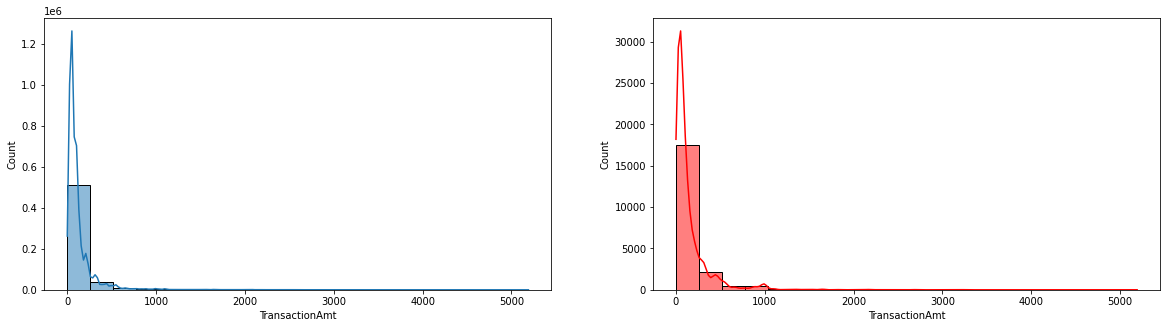

In [27]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.histplot(data=df_normal, x='TransactionAmt', kde=True, bins=20)
plt.subplot(1,2,2)
sns.histplot(data=df_fraud, x='TransactionAmt', kde=True, bins=20, color='red')
plt.show()

In [28]:
df_normal.shape

(569861, 225)

In [29]:
df_fraud.shape

(20663, 225)

Slice the normal data so we will have the same (balance) number in target column.

In [30]:
df_fraud = df_mod[df_mod['isFraud']==1]
df_normal = df_mod[df_mod['isFraud']==0][:20663]

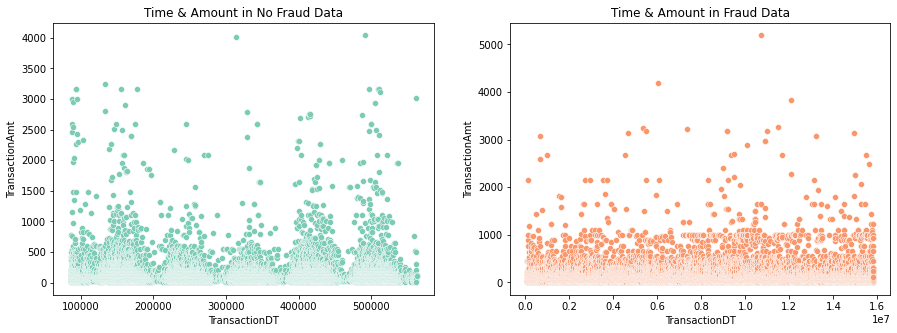

In [31]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.scatterplot(data=df_normal, x='TransactionDT', y='TransactionAmt', color='#7BCCB5')
plt.title('Time & Amount in No Fraud Data')

plt.subplot(1,2,2)
sns.scatterplot(data=df_fraud, x='TransactionDT', y='TransactionAmt', color='#F9966B')
plt.title('Time & Amount in Fraud Data')
plt.show()

## Feature Engineering

### Data Preprocessing

In [32]:
df_normal

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.50,W,13926,321.0,150.0,discover,142.0,credit,315.0,87.0,19.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,13.0,0.0,0.0,13.0,13.0,0.0,T,T,T,M2,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,0.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,T,T,M0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,315.0,315.0,T,T,T,M0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,0.0,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,0.0,111.0,T,T,T,M0,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,0.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,T,T,M0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008266,0,562048,50.00,H,9500,321.0,150.0,visa,226.0,debit,126.0,87.0,0.0,anonymous.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,T,T,M0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3008267,0,562143,15.00,H,14415,481.0,150.0,mastercard,224.0,credit,205.0,87.0,0.0,yahoo.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,T,T,M0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3008268,0,562205,100.00,H,1012,479.0,150.0,visa,162.0,credit,143.0,87.0,0.0,yahoo.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,T,T,M0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
df_fraud

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987203,1,89760,445.000,W,18268,583.0,150.0,visa,226.0,credit,251.0,87.0,0.0,aol.com,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0,57.0,57.0,52.0,0.0,0.0,80.0,0.0,374.0,T,T,T,M0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
2987240,1,90193,37.098,C,13413,103.0,185.0,visa,137.0,credit,299.0,87.0,0.0,hotmail.com,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,T,T,M2,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
2987243,1,90246,37.098,C,13413,103.0,185.0,visa,137.0,credit,299.0,87.0,0.0,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,T,T,M2,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
2987245,1,90295,37.098,C,13413,103.0,185.0,visa,137.0,credit,299.0,87.0,0.0,hotmail.com,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,T,T,M2,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
2987288,1,90986,155.521,C,16578,545.0,185.0,visa,226.0,credit,299.0,87.0,0.0,outlook.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,T,T,M2,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577361,1,15807368,1224.000,W,3278,453.0,150.0,visa,226.0,debit,191.0,87.0,26.0,yahoo.com,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,6.0,3.0,63.0,63.0,31.0,382.0,31.0,382.0,380.0,382.0,T,T,T,M0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
3577364,1,15807516,69.964,C,5812,408.0,185.0,mastercard,224.0,debit,299.0,87.0,0.0,hotmail.com,1.0,3.0,0.0,1.0,0.0,1.0,1.0,3.0,0.0,2.0,2.0,2.0,0.0,0.0,112.0,0.0,20.0,113.0,20.0,0.0,0.0,20.0,T,T,T,M2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,48.0774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0774,0.0,0.0,0.0,0.0
3577368,1,15807677,100.000,H,6758,399.0,150.0,american express,146.0,credit,299.0,87.0,0.0,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,T,T,M0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0


In [34]:
df_mod = pd.concat([df_normal, df_fraud])

In [35]:
df_mod.shape

(41326, 225)

In [36]:
df_mod.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,321.0,150.0,discover,142.0,credit,315.0,87.0,19.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,13.0,0.0,0.0,13.0,13.0,0.0,T,T,T,M2,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,0.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,T,T,M0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,315.0,315.0,T,T,T,M0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,0.0,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,0.0,111.0,T,T,T,M0,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,0.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,T,T,M0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
X = df_mod.drop(['isFraud'], axis=1)
y = df_mod['isFraud']

In [38]:
X.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,W,13926,321.0,150.0,discover,142.0,credit,315.0,87.0,19.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,13.0,0.0,0.0,13.0,13.0,0.0,T,T,T,M2,F,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,0.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,T,T,M0,T,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,315.0,315.0,T,T,T,M0,F,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,0.0,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,0.0,111.0,T,T,T,M0,T,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,0.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,T,T,M0,F,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Encode the Categorical Features

In [39]:
encode = LabelEncoder()
X['ProductCD'] = encode.fit_transform(X['ProductCD']) 
X['card4'] = encode.fit_transform(X['card4']) 
X['card6'] = encode.fit_transform(X['card6'])
X['P_emaildomain'] = encode.fit_transform(X['P_emaildomain'])
X['M1'] = encode.fit_transform(X['M1'])
X['M2'] = encode.fit_transform(X['M2'])
X['M3'] = encode.fit_transform(X['M3'])
X['M4'] = encode.fit_transform(X['M4'])
X['M5'] = encode.fit_transform(X['M5'])
X['M6'] = encode.fit_transform(X['M6'])
X['M7'] = encode.fit_transform(X['M7'])
X['M8'] = encode.fit_transform(X['M8'])
X['M9'] = encode.fit_transform(X['M9'])

### Feature Selection using Feature Importance from Random Forest

In [46]:
forest = RandomForestClassifier(random_state=42).fit(X,y)

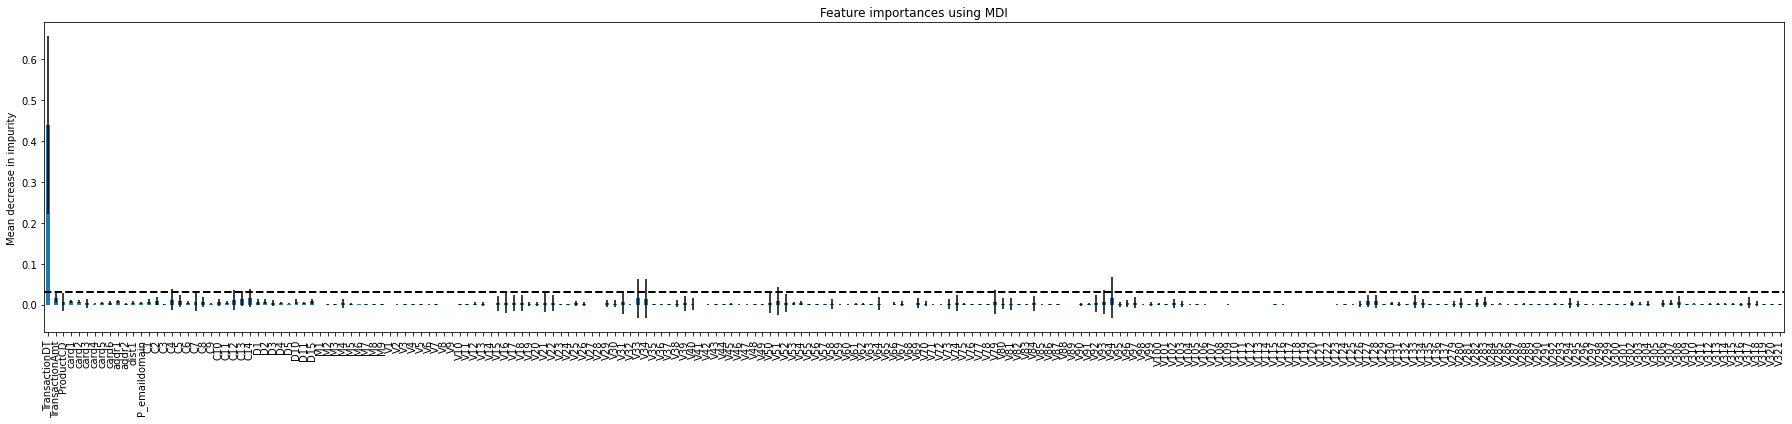

In [47]:
feature_names = X.columns
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(25,6))
forest_importances.plot.bar(yerr=std, ax=ax)
plt.axhline(0.03, color='black', linestyle='dashed', linewidth=2)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [50]:
X_train = X[['TransactionDT', 'ProductCD','TransactionAmt', 'C4', 'C14', 'V33', 'V34', 'V51', 'V94']]

In [51]:
X_train

,TransactionDT,ProductCD,TransactionAmt,C4,C14,V33,V34,V51,V94
TransactionID,,,,,,,,,
2987000,86400,4,68.500,0.0,1.0,0.0,0.0,0.0,0.0
2987001,86401,4,29.000,0.0,1.0,0.0,0.0,0.0,0.0
2987002,86469,4,59.000,0.0,1.0,0.0,0.0,0.0,0.0
2987003,86499,4,50.000,0.0,1.0,0.0,0.0,0.0,0.0
2987004,86506,1,50.000,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3577361,15807368,4,1224.000,0.0,3.0,0.0,0.0,0.0,0.0
3577364,15807516,0,69.964,1.0,0.0,1.0,1.0,1.0,1.0
3577368,15807677,1,100.000,1.0,1.0,0.0,0.0,0.0,0.0


In [52]:
# Scaling Data
scale = StandardScaler()
X_train = scale.fit_transform(X_train)

## Model Definition and Model Training

### Isolation Forest

In [54]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report

In [55]:
contamination = 0.5
isofor = IsolationForest(contamination=contamination, n_estimators=1000)
isofor.fit(X_train)

IsolationForest(contamination=0.5, n_estimators=1000)

In [56]:
y_pred_if = isofor.predict(X_train)
y_pred_if[y_pred_if == 1] = 0
y_pred_if[y_pred_if== -1] = 1
y_pred_if

array([0, 0, 0, ..., 1, 1, 1])

In [57]:
predictedrf = pd.DataFrame({'Actual': y,'Predicted': y_pred_if})
predictedrf.value_counts()

Actual  Predicted
1       1            15596
0       0            15596
1       0             5067
0       1             5067
dtype: int64

In [58]:
print(classification_report(y, y_pred_if))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75     20663
           1       0.75      0.75      0.75     20663

    accuracy                           0.75     41326
   macro avg       0.75      0.75      0.75     41326
weighted avg       0.75      0.75      0.75     41326



### Gaussian Naive Bayes

In [59]:
from sklearn.naive_bayes import GaussianNB

In [60]:
gnb = GaussianNB()
gnb.fit(X_train,y)

GaussianNB()

In [61]:
y_pred_gnb = gnb.predict(X_train)

y_pred_gnb

array([0, 0, 0, ..., 1, 1, 1])

In [62]:
predicted_gnb = pd.DataFrame({'Actual': y,'Predicted': y_pred_gnb})
predicted_gnb.value_counts()

Actual  Predicted
1       1            19827
0       0            19533
        1             1130
1       0              836
dtype: int64

In [63]:
print(classification_report(y, y_pred_gnb))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     20663
           1       0.95      0.96      0.95     20663

    accuracy                           0.95     41326
   macro avg       0.95      0.95      0.95     41326
weighted avg       0.95      0.95      0.95     41326



In [64]:
rf = RandomForestClassifier()
rf.fit(X_train, y)

RandomForestClassifier()

In [65]:
y_pred_rf = rf.predict(X_train)

y_pred_rf

array([0, 0, 0, ..., 1, 1, 1])

In [66]:
predicted_rf = pd.DataFrame({'Actual': y,'Predicted': y_pred_rf})
predicted_rf.value_counts()

Actual  Predicted
0       0            20663
1       1            20660
        0                3
dtype: int64

In [67]:
print(classification_report(y, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20663
           1       1.00      1.00      1.00     20663

    accuracy                           1.00     41326
   macro avg       1.00      1.00      1.00     41326
weighted avg       1.00      1.00      1.00     41326



## Parameter Tuning

In [68]:
# Set grid search parameter for IsolationForest
param_grid_if = [ 
  {'n_estimators': [200, 300], 
   'contamination': [0.1, 0.3]
   }
]

# Set grid search parameter for GNB
param_grid_gnb = [
  {'var_smoothing': np.logspace(0,-9, num=100)
   }
 ]

# Set grid search parameter for RandomForest
param_grid_rf = [
  {'n_estimators': [100, 200, 300],
   'criterion': ['entropy', 'gini'], 
   'max_depth': [4, 5] 
   }
 ]

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

In [70]:
# Construct grid search (Isolation Forest)
isofor = IsolationForest()
#f1sc = make_scorer(f1_score(average='micro'))
gs_if = GridSearchCV(isofor,
                     param_grid=param_grid_if,
                     scoring='f1_micro',
                     cv=5, verbose=1, return_train_score=True)
# Fit using grid search
gs_if.fit(X_train, y)
# Best accuracy
print('Best f1_score: %.2f' % gs_if.best_score_)
# Best params
print('\nBest params:\n', gs_if.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best f1_score: 0.19

Best params:
 {'contamination': 0.1, 'n_estimators': 200}


In [78]:
# Construct grid search (Isolation Forest)
gs_gnb = GridSearchCV(estimator=gnb,
                     param_grid=param_grid_gnb,
                     scoring='f1',
                     cv=5, verbose=1, return_train_score=True)
# Fit using grid search
gs_gnb.fit(X_train, y)
# Best accuracy
print('Best f1_score: %.2f' % gs_gnb.best_score_)
# Best params
print('\nBest params:\n', gs_gnb.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best f1_score: 0.95

Best params:
 {'var_smoothing': 1.232846739442066e-06}


In [72]:
# Construct grid search (Isolation Forest)
gs_rf = GridSearchCV(rf,
                     param_grid=param_grid_rf,
                     scoring='f1',
                     cv=5, verbose=1, return_train_score=True)
# Fit using grid search
gs_rf.fit(X_train, y)
# Best accuracy
print('Best f1_score: %.2f' % gs_rf.best_score_)
# Best params
print('\nBest params:\n', gs_rf.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best f1_score: 0.85

Best params:
 {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 200}


In [90]:
gs_gnb.best_estimator_

GaussianNB(var_smoothing=1.232846739442066e-06)

## Model Inference

Since the test_transaction has no target column yet, we could just predict the data with the model trained before.

In [73]:
test_tr = pd.read_csv('/content/drive/MyDrive/Job Interview Technical Test/Fraud Detection Test/test_transaction.csv')
test_tr

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.950,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.950,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.950,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679,C,13832,375.0,185.0,mastercard,224.0,debit,284.0,60.0,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506687,4170236,34214287,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,157.0,hotmail.com,hotmail.com,1.0,3.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,3.0,1.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,NaN,NaN,0.0,...,0.0,0.0,1.0,2.0,1.0,1.0,0.000000,31.723700,0.000000,0.000000,31.723700,0.000000,0.000000,31.723700,31.723700,31.723700,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506688,4170237,34214326,49.000,W,16661,490.0,150.0,visa,226.0,debit,327.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0000

In [97]:
test_data = test_tr[['TransactionID','TransactionDT', 'ProductCD','TransactionAmt', 'C4', 'C14', 'V33', 'V34', 'V51', 'V94']]

In [98]:
test_data.set_index('TransactionID', inplace=True)

In [99]:
for column in test_data.columns:
    test_data[column].fillna(test_data[column].mode()[0], inplace=True)
test_data.isnull().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


TransactionDT     0
ProductCD         0
TransactionAmt    0
C4                0
C14               0
V33               0
V34               0
V51               0
V94               0
dtype: int64

In [100]:
test_data.head()

,TransactionDT,ProductCD,TransactionAmt,C4,C14,V33,V34,V51,V94
TransactionID,,,,,,,,,
3663549,18403224,W,31.95,0.0,6.0,0.0,0.0,0.0,0.0
3663550,18403263,W,49.00,0.0,2.0,0.0,0.0,0.0,0.0
3663551,18403310,W,171.00,0.0,2.0,0.0,0.0,0.0,0.0
3663552,18403310,W,284.95,0.0,4.0,0.0,0.0,0.0,0.0
3663553,18403317,W,67.95,0.0,6.0,0.0,0.0,0.0,0.0


In [101]:
test_data['ProductCD'] = encode.fit_transform(test_data['ProductCD'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [102]:
X_test = scale.fit_transform(test_data)

In [103]:
model = gs_gnb.best_estimator_
model.fit(X_train,y)
pred = model.predict(X_test)
pred

array([1, 1, 1, ..., 1, 1, 1])

In [104]:
test_data['prediction'] = pred
test_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,TransactionDT,ProductCD,TransactionAmt,C4,C14,V33,V34,V51,V94,prediction
TransactionID,,,,,,,,,,
3663549,18403224,4,31.950,0.0,6.0,0.0,0.0,0.0,0.0,1
3663550,18403263,4,49.000,0.0,2.0,0.0,0.0,0.0,0.0,1
3663551,18403310,4,171.000,0.0,2.0,0.0,0.0,0.0,0.0,1
3663552,18403310,4,284.950,0.0,4.0,0.0,0.0,0.0,0.0,1
3663553,18403317,4,67.950,0.0,6.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
4170235,34214279,0,94.679,1.0,1.0,1.0,1.0,1.0,1.0,1
4170236,34214287,0,12.173,1.0,1.0,1.0,1.0,1.0,1.0,1
4170237,34214326,4,49.000,0.0,1.0,0.0,0.0,0.0,0.0,1


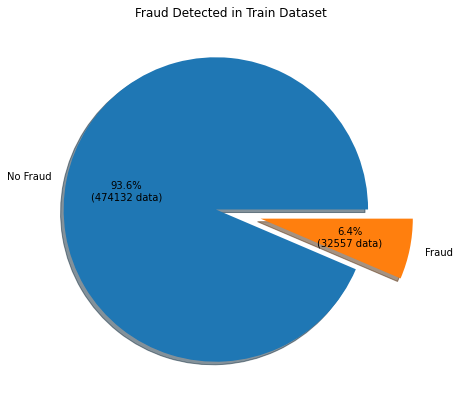

In [107]:
labels = ['No Fraud', 'Fraud']
explode=[0.1,0.2]

# Shows pie chart
plt.figure(figsize=(20,7))
plt.title('Fraud Detected in Train Dataset')
plt.pie(test_data['prediction'].value_counts(), autopct=lambda pct: func(pct, test_data['prediction'].value_counts()), 
         shadow=True, labels=labels, explode=explode)
plt.show()

## Conclusion
- The parameter tuning process could be improved by adding some more parameters and compute them to get the best parameter for the model
- The RandomForest model with default parameter achieved the highest f1-score (100%) but we assumed that it overfits, so we decided to use the tuned model of Gaussian Naive Bayes (it achieved 95% of f1-score).
- The prediction result is 32557 (from total of 506691) transaction datas are detected as fraud